## LSTM Network Training

In [ ]:
import os
import warnings
import pandas as pd

from src.stock_prediction_class import StockClass
from src.stock_prediction_numpy import DataClass
from src.stock_prediction_deep_learning import train_LSTM_network

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or '3' to suppress all messages

# Suppress other warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

In [ ]:
# import secrets
# TOKEN = STOCK_TICKER + '_' + TODAY_RUN + '_' + secrets.token_hex(16)

In [ ]:
STOCK_TICKER = "GOOG"
STOCK_START_DATE = pd.to_datetime("2024-05-24 09:30:00")
STOCK_VALIDATION_DATE = pd.to_datetime("2024-05-29 10:52:00")
STOCK_END_DATE = pd.to_datetime("2024-05-30 15:59:00")
EPOCHS = 100
BATCH_SIZE = 10
TIME_STEPS = 1
TODAY_RUN = datetime.today().strftime("%Y%m%d")
TOKEN = "GOOG"
FOLDER_PREFIX = "data/min/"
RUN_FOLDER = f"{FOLDER_PREFIX}{TOKEN}/"
WORK_DIR = os.path.join(os.getcwd(), RUN_FOLDER)
CSV_FILE = f"{WORK_DIR}data.csv"

print('Ticker: ' + STOCK_TICKER)
print('Start Date: ' + STOCK_START_DATE.strftime("%Y-%m-%d"))
print('Validation Date: ' + STOCK_VALIDATION_DATE.strftime("%Y-%m-%d"))
print('Test Run Folder: ' + RUN_FOLDER)

PROJECT_FOLDER = os.path.join(os.getcwd(), RUN_FOLDER)
if not os.path.exists(PROJECT_FOLDER):
    os.makedirs(PROJECT_FOLDER)

In [ ]:
stock_prediction = StockClass(STOCK_TICKER, 
                                   STOCK_START_DATE,
                                   STOCK_END_DATE,
                                   STOCK_VALIDATION_DATE, 
                                   PROJECT_FOLDER, 
                                   EPOCHS,
                                   TIME_STEPS,
                                   TOKEN,
                                   BATCH_SIZE)


In [ ]:
# Data loading
stock_data = DataClass()
# (x_train, y_train), (x_test, y_test), (training_data, test_data) = data.download_transform_to_numpy(
    # stock.ticker, 
    # stock.time_steps, 
    # stock.project_folder,
    # stock.start_date,
    # stock.end_date,
    # stock.validation_date)

(x_train, y_train), (x_test, y_test), (training_data, test_data) = stock_data.load_csv_transform_to_numpy(TIME_STEPS, CSV_FILE, STOCK_VALIDATION_DATE)

In [ ]:
# Execute Deep Learning model
train_LSTM_network(stock_data, stock_prediction, x_train, y_train, x_test, y_test, training_data, test_data)

## Prediction

In [52]:
def infer_data(stock_data, start_date, end_date, latest_close_price, work_dir):
    
    x_test, y_test, test_data = stock_data.generate_future_data(TIME_STEPS, start_date, end_date, latest_close_price)

    # Check if the future data is not empty
    if x_test.shape[0] > 0:
        # load the weights from our best model
        model = tf.keras.models.load_model(os.path.join(work_dir, 'model_weights.keras'))
        model.summary()

        # perform a prediction
        test_predictions_baseline = model.predict(x_test)
        test_predictions_baseline = stock_data.min_max.inverse_transform(test_predictions_baseline)
        test_predictions_baseline = pd.DataFrame(test_predictions_baseline, columns=['Predicted_Price'])

        # Combine the predicted values with dates from the test data
        predicted_dates = pd.date_range(start=test_data.index[0], periods=len(test_predictions_baseline), freq="1min")
        test_predictions_baseline['Datetime'] = predicted_dates
        
        # Reset the index for proper concatenation
        test_data.reset_index(inplace=True)
        
        # Concatenate the test_data and predicted data
        combined_data = pd.concat([test_data, test_predictions_baseline], ignore_index=True)
        
        # Plotting predictions
        plt.figure(figsize=(14, 5))
        plt.plot(combined_data['Datetime'], combined_data.Close, color='green', label='Simulated [' + STOCK_TICKER + '] price')
        plt.plot(combined_data['Datetime'], combined_data['Predicted_Price'], color='red', label='Predicted [' + STOCK_TICKER + '] price')
        plt.xlabel('Time')
        plt.ylabel('Price [USD]')
        plt.legend()
        plt.title('Simulated vs Predicted Prices')
        plt.savefig(os.path.join(work_dir, 'future_comparison.png'))
        plt.show()
    else:
        print("Error: Future data is empty.")

173.57000732421875: latest_close_price
2024-05-30 15:59:00: latest_date
2024-05-31 15:59:00: start_date
2024-06-01 15:59:00: end_date


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 50)          │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,355 (1.28 MB)

 Trainable params: 111,451 (435.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 222,904 (870.72 KB)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


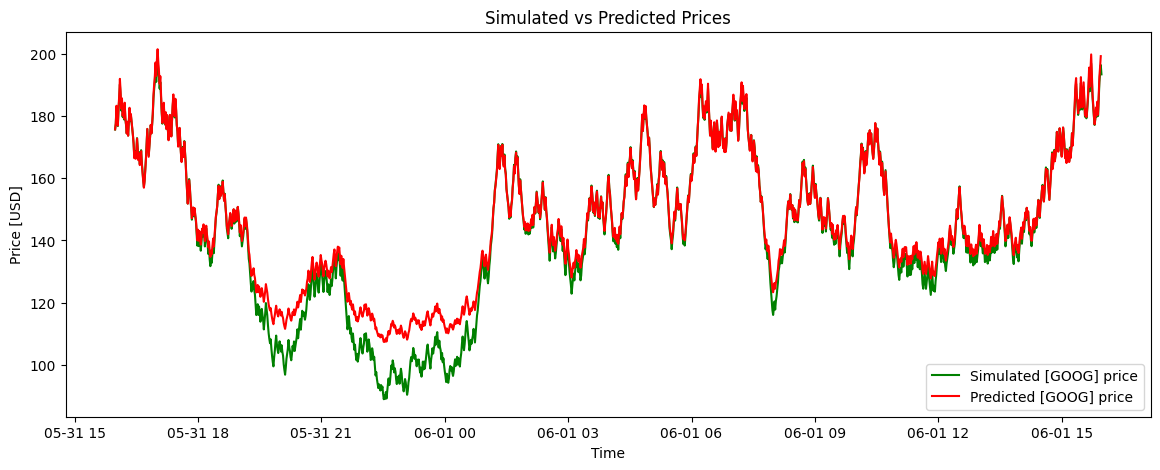

In [54]:
data = pd.read_csv(CSV_FILE)

latest_close_price = data['Close'].iloc[-1]
latest_date = data['Datetime'].iloc[-1]

print(f"{latest_close_price}: latest_close_price")
print(f"{latest_date}: latest_date")

start_date = pd.to_datetime(latest_date) + timedelta(1)
end_date = pd.to_datetime(start_date) + timedelta(1)

print(f"{start_date}: start_date")
print(f"{end_date}: end_date")

infer_data(stock_data, start_date, end_date, latest_close_price, WORK_DIR)